In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
data_dir = r'C:\Users\91738\Desktop\jupyter\garbage_image dataset'
# List the classes or categories in your dataset
classes = os.listdir(data_dir)
print(classes)


['battery', 'biological', 'cardboard', 'clothes', 'garbage.onnx', 'garbage1.onnx', 'glass', 'labels.txt', 'metal', 'model.pth', 'model.tflite', 'paper', 'plastic', 'shoes', 'trash']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: battery (Class No: 0)


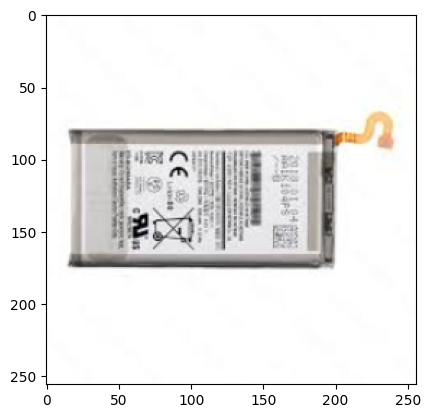

In [5]:
img, label = dataset[12]
show_sample(img, label)

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
len(dataset)

23642

In [4]:
train_ds, test_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_ds, val_ds = random_split(train_ds, [int(0.8 * len(train_ds)), len(train_ds) - int(0.8 * len(train_ds))])

In [5]:
print(len(train_ds), len(test_ds), len(val_ds))

15130 4729 3783


In [6]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

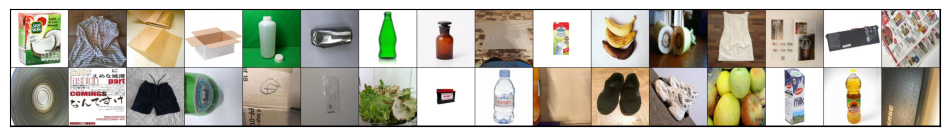

In [15]:
show_batch(train_dl)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

C:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [43]:
device = get_default_device()
device

device(type='cpu')

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
model = to_device(ResNet(), device)

In [27]:
evaluate(model, val_dl)

{'val_loss': 2.2903823852539062, 'val_acc': 0.17034968733787537}

In [28]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5984, val_loss: 1.5026, val_acc: 0.9609
Epoch 2: train_loss: 1.4966, val_loss: 1.4887, val_acc: 0.9708
Epoch 3: train_loss: 1.4825, val_loss: 1.4895, val_acc: 0.9677
Epoch 4: train_loss: 1.4773, val_loss: 1.4877, val_acc: 0.9698
Epoch 5: train_loss: 1.4732, val_loss: 1.4904, val_acc: 0.9674
Epoch 6: train_loss: 1.4698, val_loss: 1.4928, val_acc: 0.9643
Epoch 7: train_loss: 1.4685, val_loss: 1.4831, val_acc: 0.9747
Epoch 8: train_loss: 1.4692, val_loss: 1.4885, val_acc: 0.9706


In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

NameError: name 'history' is not defined

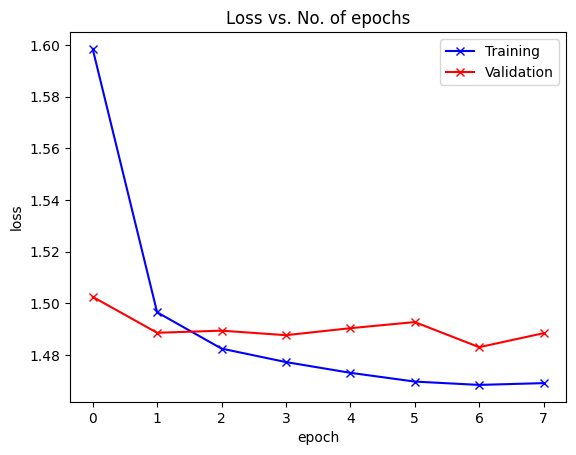

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: clothes , Predicted: clothes


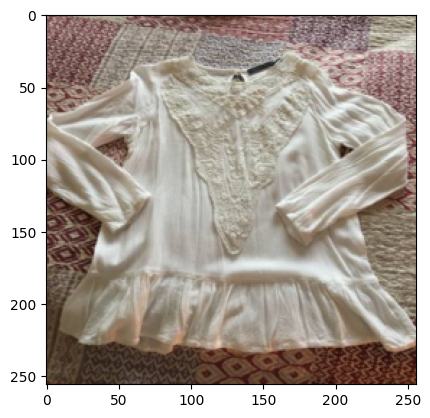

In [44]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


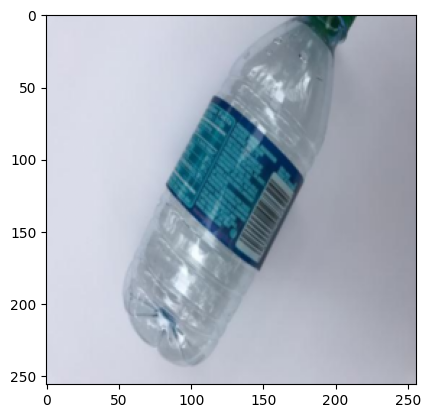

In [35]:
img, label = test_ds[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [18]:
torch.save(model.state_dict(), r'C:\Users\91738\Desktop\jupyter\model.pth')


In [13]:
 import torch
 import onnx
 import torchvision

In [14]:
input_shape = (1, 3, 256, 256)
 # Export  PyTorch model to ONNX format
torch.onnx.export(model, torch.randn(input_shape), 'garbage.onnx', opset_version=11)

In [23]:
!pip install onnx-tf


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
!pip install tensorflow-probability



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import onnx_tf

C:\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and 

In [16]:
from onnx_tf.backend import prepare

In [17]:
!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.


In [18]:
!pip install torchvision


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import onnx
from onnx_tf.backend import prepare

In [20]:
# model = onnx.load(r'C:\Users\91738\Desktop\jupyter\garbage.onnx')
# print("Model Inputs: ", [inp.name for inp in model.graph.input])
# # Import the ONNX model to Tensorflow
# tf_rep = prepare(model)

Model Inputs:  ['input.1']


In [21]:
from onnx import helper

In [26]:
import onnx
from onnx import helper

# Load the ONNX model
onnx_model = onnx.load(r'C:\Users\91738\Desktop\jupyter\garbage.onnx')

# Define the mapping from old names to new names
name_map = {"input.1": "input_1"}

# Initialize a list to hold the new inputs
new_inputs = []

# Iterate over the inputs and change their names if needed
for inp in onnx_model.graph.input:
    if inp.name in name_map:
        # Create a new ValueInfoProto with the new name
        new_inp = helper.make_tensor_value_info(name_map[inp.name],
                                                inp.type.tensor_type.elem_type,
                                                [dim.dim_value for dim in inp.type.tensor_type.shape.dim])
        new_inputs.append(new_inp)
    else:
        new_inputs.append(inp)

# Clear the old inputs and add the new ones
onnx_model.graph.ClearField("input")
onnx_model.graph.input.extend(new_inputs)

# Go through all nodes in the model and replace the old input name with the new one
for node in onnx_model.graph.node:
    for i, input_name in enumerate(node.input):
        if input_name in name_map:
            node.input[i] = name_map[input_name]

# Save the renamed ONNX model
onnx.save(onnx_model, 'garbage1.onnx')


In [27]:
model = onnx.load(r'C:\Users\91738\Desktop\jupyter\garbage1.onnx')

# Import the ONNX model to Tensorflow
tf_rep = prepare(model)

In [28]:
tf_rep.export_graph('garbage1.pb')

INFO:absl:Function `__call__` contains input name(s) x, y with unsupported characters which will be renamed to transpose_161_x, add_52_y in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: garbage1.pb\assets


INFO:tensorflow:Assets written to: garbage1.pb\assets
INFO:absl:Writing fingerprint to garbage1.pb\fingerprint.pb


In [30]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model(r'C:\Users\91738\Desktop\jupyter\garbage1.pb')  # use your directory path
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [31]:
# Assuming dataset.classes is a list containing class labels
with open("labels.txt", "w") as f:
    for label in dataset.classes:
        f.write(label + "\n")


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

In [13]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet() 

In [14]:
model.load_state_dict(torch.load(r'C:\Users\91738\Desktop\jupyter\garbage_image dataset\model.pth'))

<All keys matched successfully>

In [15]:
model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

Label: glass , Predicted: glass


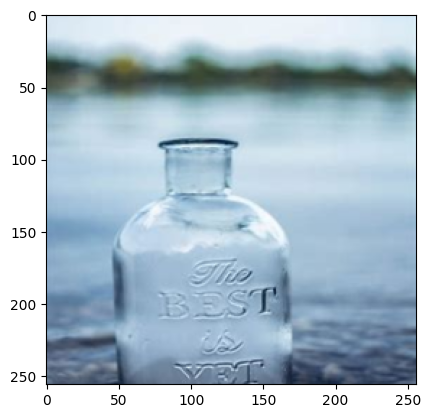

In [16]:
import matplotlib.pyplot as plt

# Assuming predict_image function is defined somewhere
def predict_image(img, model):
    # Your prediction logic here
    # For example:
    model.eval()
    with torch.no_grad():
        output = model(img.unsqueeze(0))  # Add a batch dimension
        _, predicted = torch.max(output, 1)
        return dataset.classes[predicted.item()]

img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))


Label: clothes , Predicted: clothes


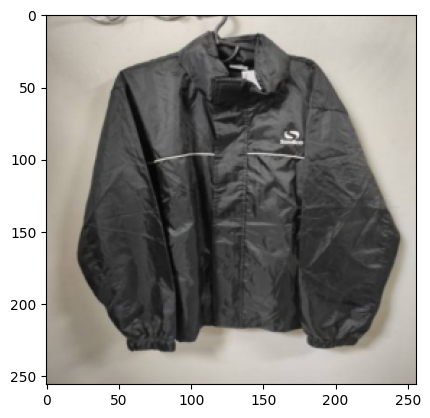

In [22]:

img, label = test_ds[400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [17]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
import cv2
import numpy as np

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

In [19]:
def detect_garbage(frame):
    # Preprocess input image
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(img)
        probabilities = torch.sigmoid(output)

    # Process model output (you can customize this based on your needs)
    _, predicted_class = torch.max(probabilities, 1)
    class_index = predicted_class.item()
    predicted_class_label = dataset.classes[class_index]
    confidence = probabilities[0, class_index].item()

    return predicted_class_label, confidence


In [36]:
cap = cv2.VideoCapture(0)

In [30]:
usb_camera_index = 1  # Change this index if needed

# Create a VideoCapture object by specifying the camera index
cap = cv2.VideoCapture(usb_camera_index)

In [37]:
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Perform garbage detection
    label, confidence = detect_garbage(frame)
    
    # Display result
    cv2.putText(frame, f"{label} ({confidence:.2f})", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Garbage Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


In [35]:
cap.release()
cv2.destroyAllWindows()

In [22]:
evaluate(model, val_dl)

{'val_loss': 1.4719699621200562, 'val_acc': 0.9893229007720947}

In [10]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [12]:
def get_all_preds(model, dataloader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for images, labels in dataloader:
            preds = model(images)
            all_preds = torch.cat(
                (all_preds, preds), dim=0
            )
            all_labels = torch.cat(
                (all_labels, labels), dim=0
            )
    return all_preds, all_labels


In [23]:
val_preds, val_labels = get_all_preds(model, val_dl)

In [25]:
# Convert predictions and labels to class indices
val_preds_class = val_preds.argmax(dim=1).numpy()
val_labels_class = val_labels.numpy()

In [32]:
print(val_preds_class)

['cardboard', 'glass', 'clothes', 'glass', 'clothes', 'cardboard', 'shoes', 'glass', 'paper', 'cardboard', 'clothes', 'clothes', 'cardboard', 'clothes', 'shoes', 'clothes', 'plastic', 'trash', 'plastic', 'clothes', 'plastic', 'cardboard', 'glass', 'plastic', 'plastic', 'glass', 'biological', 'cardboard', 'glass', 'metal', 'shoes', 'plastic', 'cardboard', 'cardboard', 'clothes', 'cardboard', 'clothes', 'clothes', 'glass', 'plastic', 'glass', 'plastic', 'cardboard', 'cardboard', 'biological', 'glass', 'glass', 'metal', 'glass', 'glass', 'paper', 'glass', 'clothes', 'clothes', 'glass', 'clothes', 'metal', 'metal', 'metal', 'paper', 'battery', 'metal', 'clothes', 'biological', 'plastic', 'cardboard', 'glass', 'glass', 'plastic', 'cardboard', 'trash', 'plastic', 'plastic', 'paper', 'glass', 'metal', 'clothes', 'plastic', 'paper', 'glass', 'clothes', 'plastic', 'plastic', 'biological', 'clothes', 'clothes', 'paper', 'metal', 'glass', 'glass', 'clothes', 'trash', 'metal', 'plastic', 'shoes', 

In [33]:
print(val_labels_class)

['cardboard', 'glass', 'clothes', 'glass', 'clothes', 'cardboard', 'shoes', 'glass', 'paper', 'cardboard', 'clothes', 'clothes', 'cardboard', 'clothes', 'shoes', 'clothes', 'plastic', 'metal', 'plastic', 'clothes', 'plastic', 'cardboard', 'glass', 'plastic', 'plastic', 'glass', 'biological', 'cardboard', 'glass', 'metal', 'shoes', 'plastic', 'cardboard', 'cardboard', 'clothes', 'cardboard', 'clothes', 'clothes', 'glass', 'plastic', 'glass', 'glass', 'cardboard', 'cardboard', 'biological', 'glass', 'glass', 'metal', 'glass', 'glass', 'paper', 'glass', 'clothes', 'clothes', 'glass', 'clothes', 'metal', 'metal', 'metal', 'paper', 'battery', 'metal', 'clothes', 'biological', 'plastic', 'cardboard', 'glass', 'glass', 'plastic', 'cardboard', 'trash', 'plastic', 'plastic', 'paper', 'glass', 'metal', 'clothes', 'plastic', 'paper', 'glass', 'clothes', 'plastic', 'plastic', 'biological', 'clothes', 'clothes', 'paper', 'metal', 'glass', 'glass', 'clothes', 'trash', 'metal', 'plastic', 'shoes', 'b

In [34]:
print(dataset.class_to_idx)

{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [36]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
val_preds_class = [idx_to_class[int(cls_idx)] if cls_idx.isdigit() else cls_idx for cls_idx in val_preds_class]
val_labels_class = [idx_to_class[int(cls_idx)] if cls_idx.isdigit() else cls_idx for cls_idx in val_labels_class]


In [37]:
report = classification_report(val_labels_class, val_preds_class)
print(report)

              precision    recall  f1-score   support

     battery       1.00      0.99      1.00       158
  biological       0.99      0.99      0.99       167
   cardboard       0.99      0.99      0.99       360
     clothes       0.99      1.00      0.99       823
       glass       1.00      0.98      0.99       642
       metal       0.98      0.99      0.99       299
       paper       0.99      0.99      0.99       413
     plastic       0.97      0.99      0.98       438
       shoes       0.99      0.98      0.99       352
       trash       0.98      0.99      0.99       131

    accuracy                           0.99      3783
   macro avg       0.99      0.99      0.99      3783
weighted avg       0.99      0.99      0.99      3783



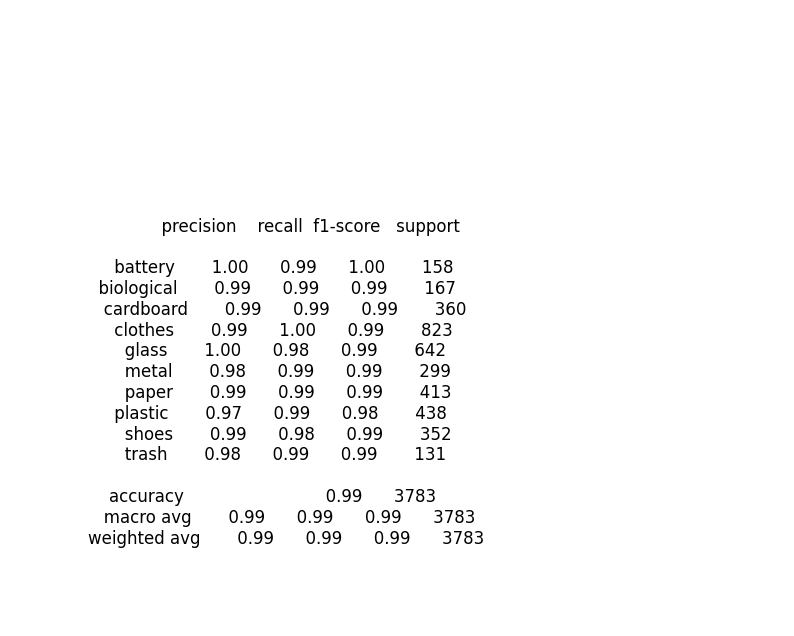

In [38]:
plt.figure(figsize=(10, 8))
plt.text(0.1, 0.1, report, fontsize=12)
plt.axis('off')
plt.show()